In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

# Constants

In [3]:
# Constants
TEST_DATA_DIR = 'data/test'
TRAIN_DATA_DIR = 'raw-data/train'
METADATA_PATH = 'raw-data/train.csv'

IMG_WIDTH = 32
IMG_HEIGTH = 32
BATCH_SIZE = 32
EPOCHS = 15

# Load, augment & preprocess data

In [4]:
# Load labels
metadata = pd.read_csv(METADATA_PATH)
metadata.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [5]:
train_data = []

for index, row in metadata.iterrows():
    image = cv2.imread(f'{TRAIN_DATA_DIR}/{row.id}')
    label = 'has_cactus' if row.has_cactus else "no_cactus" 
    train_data.append({'image': image, 'label': label})

    # Augment 30% of the data
    if np.random.random() < 0.3:
        # Horizontal or vertical flip
        flag = np.random.randint(0, 1)
        image = cv2.flip(image, flag)
        train_data.append({'image': image, 'label': label})
        
# Convert to numpy array in order to shuffle the data
train_data = np.asarray(train_data)
np.random.shuffle(train_data)
print(len(train_data))

22759


In [6]:
# Split into lists of images and labels
X =  [x['image'] for x in train_data]
y = [x['label'] for x in train_data]

# Encode label
encoder = LabelBinarizer()
y = encoder.fit_transform(y)
# Horizontally stack the array to get it into the correct shape
y = np.hstack((y, 1 - y))

# Split into training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Convert to numpy arrays for Keras
X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Build model
Based on this article: https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363 it is better to use small kernel sizes, like 3x3, for images where the usefull features are local. This is the case for my images where a cactus can be in different spots of the picture and often does not take up the entire image.

In [7]:
# Build base model.
base_model = Sequential()
kernel_size = (3, 3)

base_model.add(Conv2D(64, kernel_size=kernel_size, activation='relu', input_shape=(IMG_HEIGTH, IMG_WIDTH, 3)))
base_model.add(Dropout(0.3))
base_model.add(Conv2D(32, kernel_size=kernel_size, activation='relu'))
base_model.add(Dropout(0.3))
base_model.add(MaxPooling2D((2,2), strides=(2, 2)))
base_model.add(Flatten())
base_model.add(Dense(2, activation='softmax'))

In [8]:
base_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        18464     
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1

In [9]:
base_history = base_model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/15
569/569 [==============================] - 43s 76ms/step - loss: 2.6016 - accuracy: 0.7352
Epoch 2/15
569/569 [==============================] - 44s 78ms/step - loss: 0.3356 - accuracy: 0.8592
Epoch 3/15
569/569 [==============================] - 42s 74ms/step - loss: 0.3037 - accuracy: 0.8698
Epoch 4/15
569/569 [==============================] - 41s 72ms/step - loss: 0.3275 - accuracy: 0.8669
Epoch 5/15
569/569 [==============================] - 41s 73ms/step - loss: 0.3137 - accuracy: 0.8711
Epoch 6/15
569/569 [==============================] - 42s 73ms/step - loss: 0.3457 - accuracy: 0.8713
Epoch 7/15
569/569 [==============================] - 40s 71ms/step - loss: 0.3016 - accuracy: 0.8816
Epoch 8/15
569/569 [==============================] - 43s 76ms/step - loss: 0.3179 - accuracy: 0.8802
Epoch 9/15
569/569 [==============================] - 40s 69ms/step - loss: 0.3254 - accuracy: 0.8823
Epoch 10/15
569/569 [==============================] - 39s 69ms/step - loss: 0.367

# Evaluate model

Text(0.5, 0, 'Epoch')

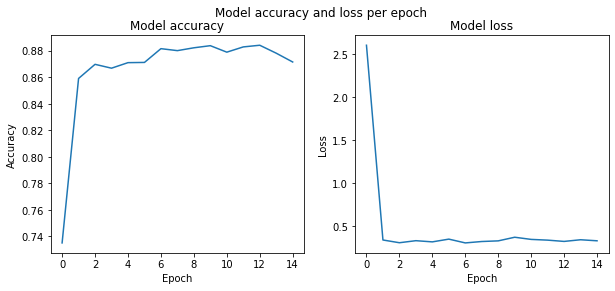

In [10]:
# Visualize accuracy
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Model accuracy and loss per epoch')

axes[0].plot(base_history.history['accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')

axes[1].plot(base_history.history['loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')

In [11]:
# Evaluate on test set
scores = base_model.predict(X_test)
predictions = np.argmax(scores, axis=1)

true = np.argmax(y_test, axis=1)

# inverse the encoding of the labels
predictions = encoder.inverse_transform(predictions)
true = encoder.inverse_transform(true)

In [13]:
labels = ['has_cactus', 'no_cactus']

df = pd.DataFrame(
    data=confusion_matrix(true, predictions, labels=labels),
    columns=labels,
    index=labels
)

df.head()

,has_cactus,no_cactus
has_cactus,1170,4
no_cactus,918,2460


In [15]:
# Calculate True Negative (tn), False Positive (fp), False Negative (fn) and True Positive (tp)
# TODO: Table klopt niet. 
tn, fp, fn, tp = confusion_matrix(true, predictions).ravel()

table = pd.DataFrame({'type': ['True Negative', 'False Positive', 'False Negative', 'True Positive'], 'value': [tn, fp, fn, tp]})

table.head()

,type,value
0,True Negative,1170
1,False Positive,4
2,False Negative,918
3,True Positive,2460


In [16]:
# TODO: Berekeningen kloppen niet.
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = ((2 * recall) * precision) / (recall + precision)

print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1 Score: {f1}')

Recall: 0.7282415630550622
Precision: 0.9983766233766234
F1 Score: 0.8421773365285862


In [112]:
# Show images where the prediction was wrong
fn_images = []
fp_images = []

for index, (predicted_label, true_label) in enumerate(zip(predictions, true)):
    if str(predicted_label) == 'no_cactus' and str(true_label) == 'has_cactus':
        fn_images.append(X_test[index])

# Get Indices of False Positives
for index, (predicted_label, true_label) in enumerate(zip(predictions, true)):
    if str(predicted_label) == 'has_cactus' and str(true_label) == 'no_cactus':
        fp_images.append(X_test[index])

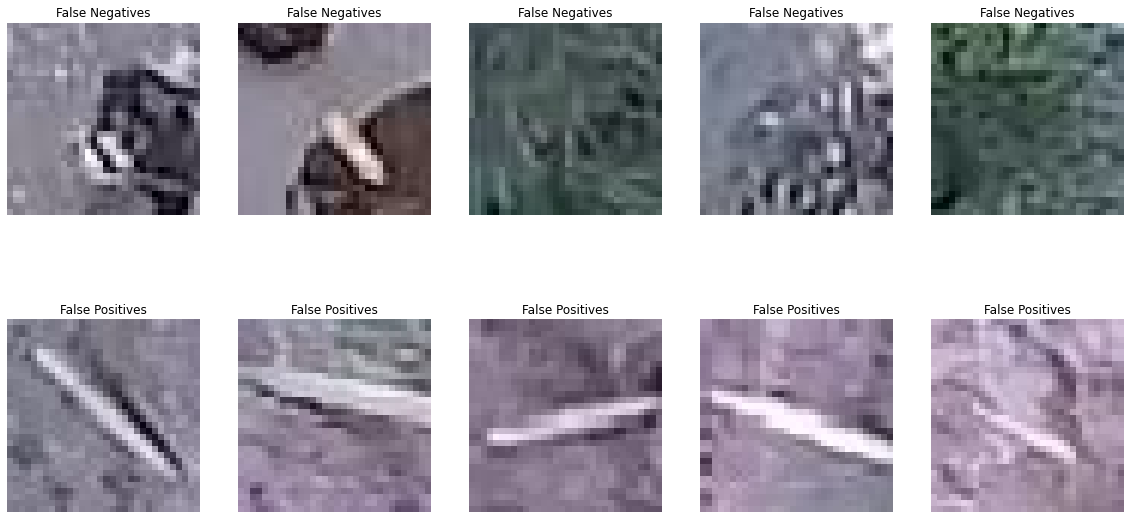

In [115]:
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
idx = np.random.randint(len(fn_images), size=5)

np.random.shuffle(fn_images)
np.random.shuffle(fp_images)

for index, img in enumerate(fn_images[:5]):
    axes[0, index].imshow(img)
    axes[0, index].axis('off')
    axes[0, index].set_title('False Negatives')

for index, img in enumerate(fp_images[:5]):
    axes[1, index].imshow(img)
    axes[1, index].axis('off')
    axes[1, index].set_title('False Positives')

# Export model

In [ ]:
base_model.save('models/base_cnn')